<a href="https://colab.research.google.com/github/fulllz/DSProjects/blob/main/NLP_2_Named_Entity_Recognition_using_Spacy_and_LSTMs_in_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
from pprint import pprint
from bs4 import BeautifulSoup
import requests
import re

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional

# Part1: Ner with Spacy

In [ ]:
def url_to_string(url):
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html, 'html5lib')
    for script in soup(["script", "style", 'aside']):
        script.extract()
    return " ".join(re.split(r'[\n\t]+', soup.get_text()))

In [ ]:
ny_bb = url_to_string('https://www.nytimes.com/2018/08/13/us/politics/peter-strzok-fired-fbi.html?hp&action=click&pgtype=Homepage&clickSource=story-heading&module=first-column-region&region=top-news&WT.nav=top-news')
article = nlp(ny_bb)
len(article.ents)

154

In [ ]:
labels = [x.label_ for x in article.ents]
Counter(labels)

Counter({'CARDINAL': 3,
         'DATE': 23,
         'GPE': 9,
         'LOC': 1,
         'NORP': 2,
         'ORDINAL': 1,
         'ORG': 38,
         'PERSON': 77})

In [ ]:
items = [x.text for x in article.ents]
Counter(items).most_common(3)

[('Strzok', 29), ('F.B.I.', 19), ('Trump', 13)]

In [ ]:
sentences = [x for x in article.sents]
print(sentences[20])

A spokeswoman for the F.B.I. did not respond to a message seeking comment about why Mr. Strzok was dismissed rather than demoted.


In [ ]:
displacy.render(nlp(str(sentences[20])), jupyter=True, style='ent')

In [ ]:
displacy.render(nlp(str(sentences[20])), style='dep', jupyter = True, options = {'distance': 120})

In [ ]:
[(x.orth_,x.pos_, x.lemma_) for x in [y 
                                      for y
                                      in nlp(str(sentences[20])) 
                                      if not y.is_stop and y.pos_ != 'PUNCT']]

[('spokeswoman', 'NOUN', 'spokeswoman'),
 ('F.B.I.', 'PROPN', 'F.B.I.'),
 ('respond', 'VERB', 'respond'),
 ('message', 'NOUN', 'message'),
 ('seeking', 'VERB', 'seek'),
 ('comment', 'NOUN', 'comment'),
 ('Mr.', 'PROPN', 'Mr.'),
 ('Strzok', 'PROPN', 'Strzok'),
 ('dismissed', 'VERB', 'dismiss'),
 ('demoted', 'VERB', 'demote')]

In [ ]:
dict([(str(x), x.label_) for x in nlp(str(sentences[20])).ents])

{'F.B.I.': 'ORG', 'Strzok': 'PERSON'}

In [ ]:
print([(x, x.ent_iob_, x.ent_type_) for x in sentences[20]])

[(A, 'O', ''), (spokeswoman, 'O', ''), (for, 'O', ''), (the, 'O', ''), (F.B.I., 'B', 'ORG'), (did, 'O', ''), (not, 'O', ''), (respond, 'O', ''), (to, 'O', ''), (a, 'O', ''), (message, 'O', ''), (seeking, 'O', ''), (comment, 'O', ''), (about, 'O', ''), (why, 'O', ''), (Mr., 'O', ''), (Strzok, 'B', 'PERSON'), (was, 'O', ''), (dismissed, 'O', ''), (rather, 'O', ''), (than, 'O', ''), (demoted, 'O', ''), (., 'O', '')]


In [ ]:
displacy.render(article, jupyter=True, style='ent')

# Part2: Ner with LSTM and Bi-LSTM

In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving ner_dataset.csv to ner_dataset.csv


In [ ]:
data = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape')
data = data.fillna(method = 'ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
data.nunique()

Sentence #    47959
Word          35178
POS              42
Tag              17
dtype: int64

In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)
num_words

35179

In [ ]:
words_tag = list(set(data["Tag"].values))
# words_tag.append("ENDPAD")
num_words_tag = len(words_tag)
num_words_tag

17

In [ ]:
num_words,num_words_tag
group = data.groupby(data["Sentence #"])
# group.groups

# Retreive  Sentences and Corresponding Tags

In [ ]:
class Get_sentence(object):
    def __init__(self,data):
        self.n_sent=1
        self.data = data
        agg_func = lambda s:[(w,p,t) for w,p,t in zip(s["Word"].values.tolist(),
                                                     s["POS"].values.tolist(),
                                                     s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = Get_sentence(data)
sentence = getter.sentences
sentence[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

# Mappings between sentences and tags

In [ ]:
word_idx = {w : i+1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(words_tag)}

> # Padding input Sentences and creating train/test split

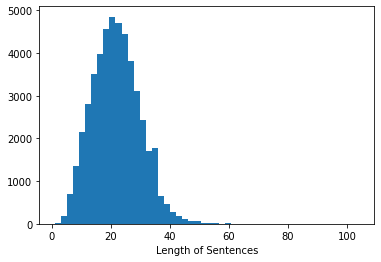

In [ ]:
plt.hist([len(s) for s in sentence],bins= 50)
plt.xlabel("Length of Sentences")
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50
X = [[word_idx[w[0]] for w in s] for s in sentence]
X = pad_sequences(maxlen = max_len,sequences = X,padding = 'post',value = num_words-1)
y = [[tag_idx[w[2]] for w in s] for s in sentence]
y = pad_sequences(maxlen = max_len,sequences = y,padding = 'post',value = tag_idx['O'])
y = [to_categorical(i,num_classes = num_words_tag) for i in  y]

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state=1)

# LSTM Model


In [ ]:
embedding_dim=128
#vocab_size=len(tokeniser.word_index)+1
lstm_units=128
#max_len=128

input_word = Input(shape = (max_len,))
model1 = Embedding(input_dim = num_words,output_dim = embedding_dim,input_length = max_len)(input_word)

model1 = LSTM(units=embedding_dim,return_sequences=True)(model1)
out = TimeDistributed(Dense(num_words_tag,activation = 'softmax'))(model1)
model1 = Model(input_word,out)
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 128)           4502912   
_________________________________________________________________
lstm (LSTM)                  (None, 50, 128)           131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            2193      
Total params: 4,636,689
Trainable params: 4,636,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
# history = model.fit(X_train,np.array(y_train),validation_data=(X_val,np.array(y_val)),batch_size = 32,epochs = 3)

In [ ]:
history1 = model1.fit(
    x_train,np.array(y_train),
    validation_split =0.2,
    batch_size = 64,
    epochs = 3,
    verbose =1
)

Epoch 1/3
540/540 [==============================] - 67s 67ms/step - loss: 0.5436 - accuracy: 0.9267 - val_loss: 0.1132 - val_accuracy: 0.9717
Epoch 2/3
540/540 [==============================] - 35s 66ms/step - loss: 0.0892 - accuracy: 0.9778 - val_loss: 0.0657 - val_accuracy: 0.9819
Epoch 3/3
540/540 [==============================] - 36s 66ms/step - loss: 0.0511 - accuracy: 0.9854 - val_loss: 0.0585 - val_accuracy: 0.9827


> #  BiLSTM Model

In [ ]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim = num_words,output_dim = max_len,input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100,return_sequences = True, recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_words_tag,activation = 'softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

> Training Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
# from livelossplot import PlotLossesKeras
early_stopping = EarlyStopping(monitor = 'val_accuracy',patience =2,verbose = 0,mode = 'max',restore_best_weights = False)
callbacks = [early_stopping]

history = model.fit(
    x_train,np.array(y_train),
    validation_split =0.2,
    batch_size = 64,
    epochs = 3,
    verbose =1
)




Epoch 1/3
540/540 [==============================] - 247s 449ms/step - loss: 0.5372 - accuracy: 0.9236 - val_loss: 0.1249 - val_accuracy: 0.9647
Epoch 2/3
540/540 [==============================] - 241s 445ms/step - loss: 0.0970 - accuracy: 0.9730 - val_loss: 0.0607 - val_accuracy: 0.9823
Epoch 3/3
540/540 [==============================] - 240s 444ms/step - loss: 0.0501 - accuracy: 0.9855 - val_loss: 0.0518 - val_accuracy: 0.9844


In [ ]:
model.evaluate(x_test,np.array(y_test))

150/150 [==============================] - 6s 37ms/step - loss: 0.0544 - accuracy: 0.9839


[0.054424818605184555, 0.9839240908622742]

In [ ]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
# print(np.shape(p))
# print(p)
p = np.argmax(p, axis=-1)


y_true = np.argmax(np.array(y_test), axis=-1)[i]

print("{:15}{:5}\t{}\n".format("Word", "True", "Pred"))
print("-"*30)

for (w, t, pred) in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], words_tag[t], words_tag[pred]))

Word           True 	Pred

------------------------------
North          B-geo	B-geo
Korea          I-geo	I-geo
had            O	O
boycotted      O	O
the            O	O
negotiations   O	O
for            O	O
more           O	O
than           O	O
a              O	O
year           O	O
,              O	O
citing         O	O
a              O	O
hostile        O	O
U.S.           B-geo	B-geo
policy         O	O
.              O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje         O	O
Nsanje